In [4]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings
from scipy.ndimage.measurements import label

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [3]:
cd ..

/home/ck/pythonWorkspace


In [5]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [7]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT_u_correlation_SouthAmerica_allTest.nc')
corr_end = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT_u_correlation_SouthAmerica_2005-2017.nc')

In [8]:
def readERA():

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [9]:
era = readERA()
era.sel(latitude=slice(-18,-5), longitude=slice(-81,-68))

<xarray.Dataset>
Dimensions:    (latitude: 53, longitude: 53, time: 14610)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -68.5 -68.25 -68.0
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... -5.5 -5.25 -5.0
    level      int32 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 ...

In [10]:
era_all = era['u'].where(era['u']<=-5).groupby('time.year').count('time').mean('year')

In [11]:
era_all

<xarray.DataArray 'u' (latitude: 125, longitude: 97)>
array([[  7.7  ,   7.4  ,   7.2  , ...,   5.425,   5.4  ,   5.65 ],
       [  7.475,   7.125,   7.1  , ...,   5.7  ,   5.75 ,   5.625],
       [  6.975,   6.825,   6.725, ...,   5.75 ,   5.8  ,   5.95 ],
       ...,
       [168.575, 167.375, 166.875, ...,  92.4  ,  91.925,  91.425],
       [164.   , 162.325, 161.775, ...,  91.35 ,  91.1  ,  90.3  ],
       [159.725, 158.2  , 157.35 , ...,  90.15 ,  89.65 ,  89.15 ]])
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
    level      int32 250

In [12]:
era_end = era['u'].sel(time=(era['time.year']>1998))
era_end = era_end.where(era_end<=-5).groupby('time.year').count('time').mean('year')

In [13]:
era_end

<xarray.DataArray 'u' (latitude: 125, longitude: 97)>
array([[  7.15,   6.95,   6.85, ...,   4.7 ,   4.6 ,   4.8 ],
       [  6.75,   6.55,   6.7 , ...,   5.  ,   5.  ,   4.75],
       [  6.45,   6.3 ,   6.3 , ...,   5.05,   5.1 ,   5.1 ],
       ...,
       [187.2 , 186.25, 186.7 , ..., 110.35, 109.65, 108.75],
       [182.8 , 181.65, 181.4 , ..., 108.35, 108.4 , 107.25],
       [178.5 , 177.6 , 177.35, ..., 106.4 , 105.15, 104.9 ]])
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
    level      int32 250

In [14]:
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_end = corr_end.assign_coords(dayofyear=corr_end.dayofyear.values)

In [15]:
corr_all.years

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

In [16]:
corr_all = corr_all.sel(latitude=slice(-18,-5), longitude=slice(-81,-68))
corr_end = corr_end.sel(latitude=slice(-18,-5), longitude=slice(-81,-68))

In [17]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-82,-65), lat=slice(-20,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [18]:
corr_all_num = corr_all['r'].where(corr_all['pval']<=0.05).count('dayofyear')

In [19]:
corr_end_num = corr_end['r'].where(corr_end['pval']<=0.05).count('dayofyear')

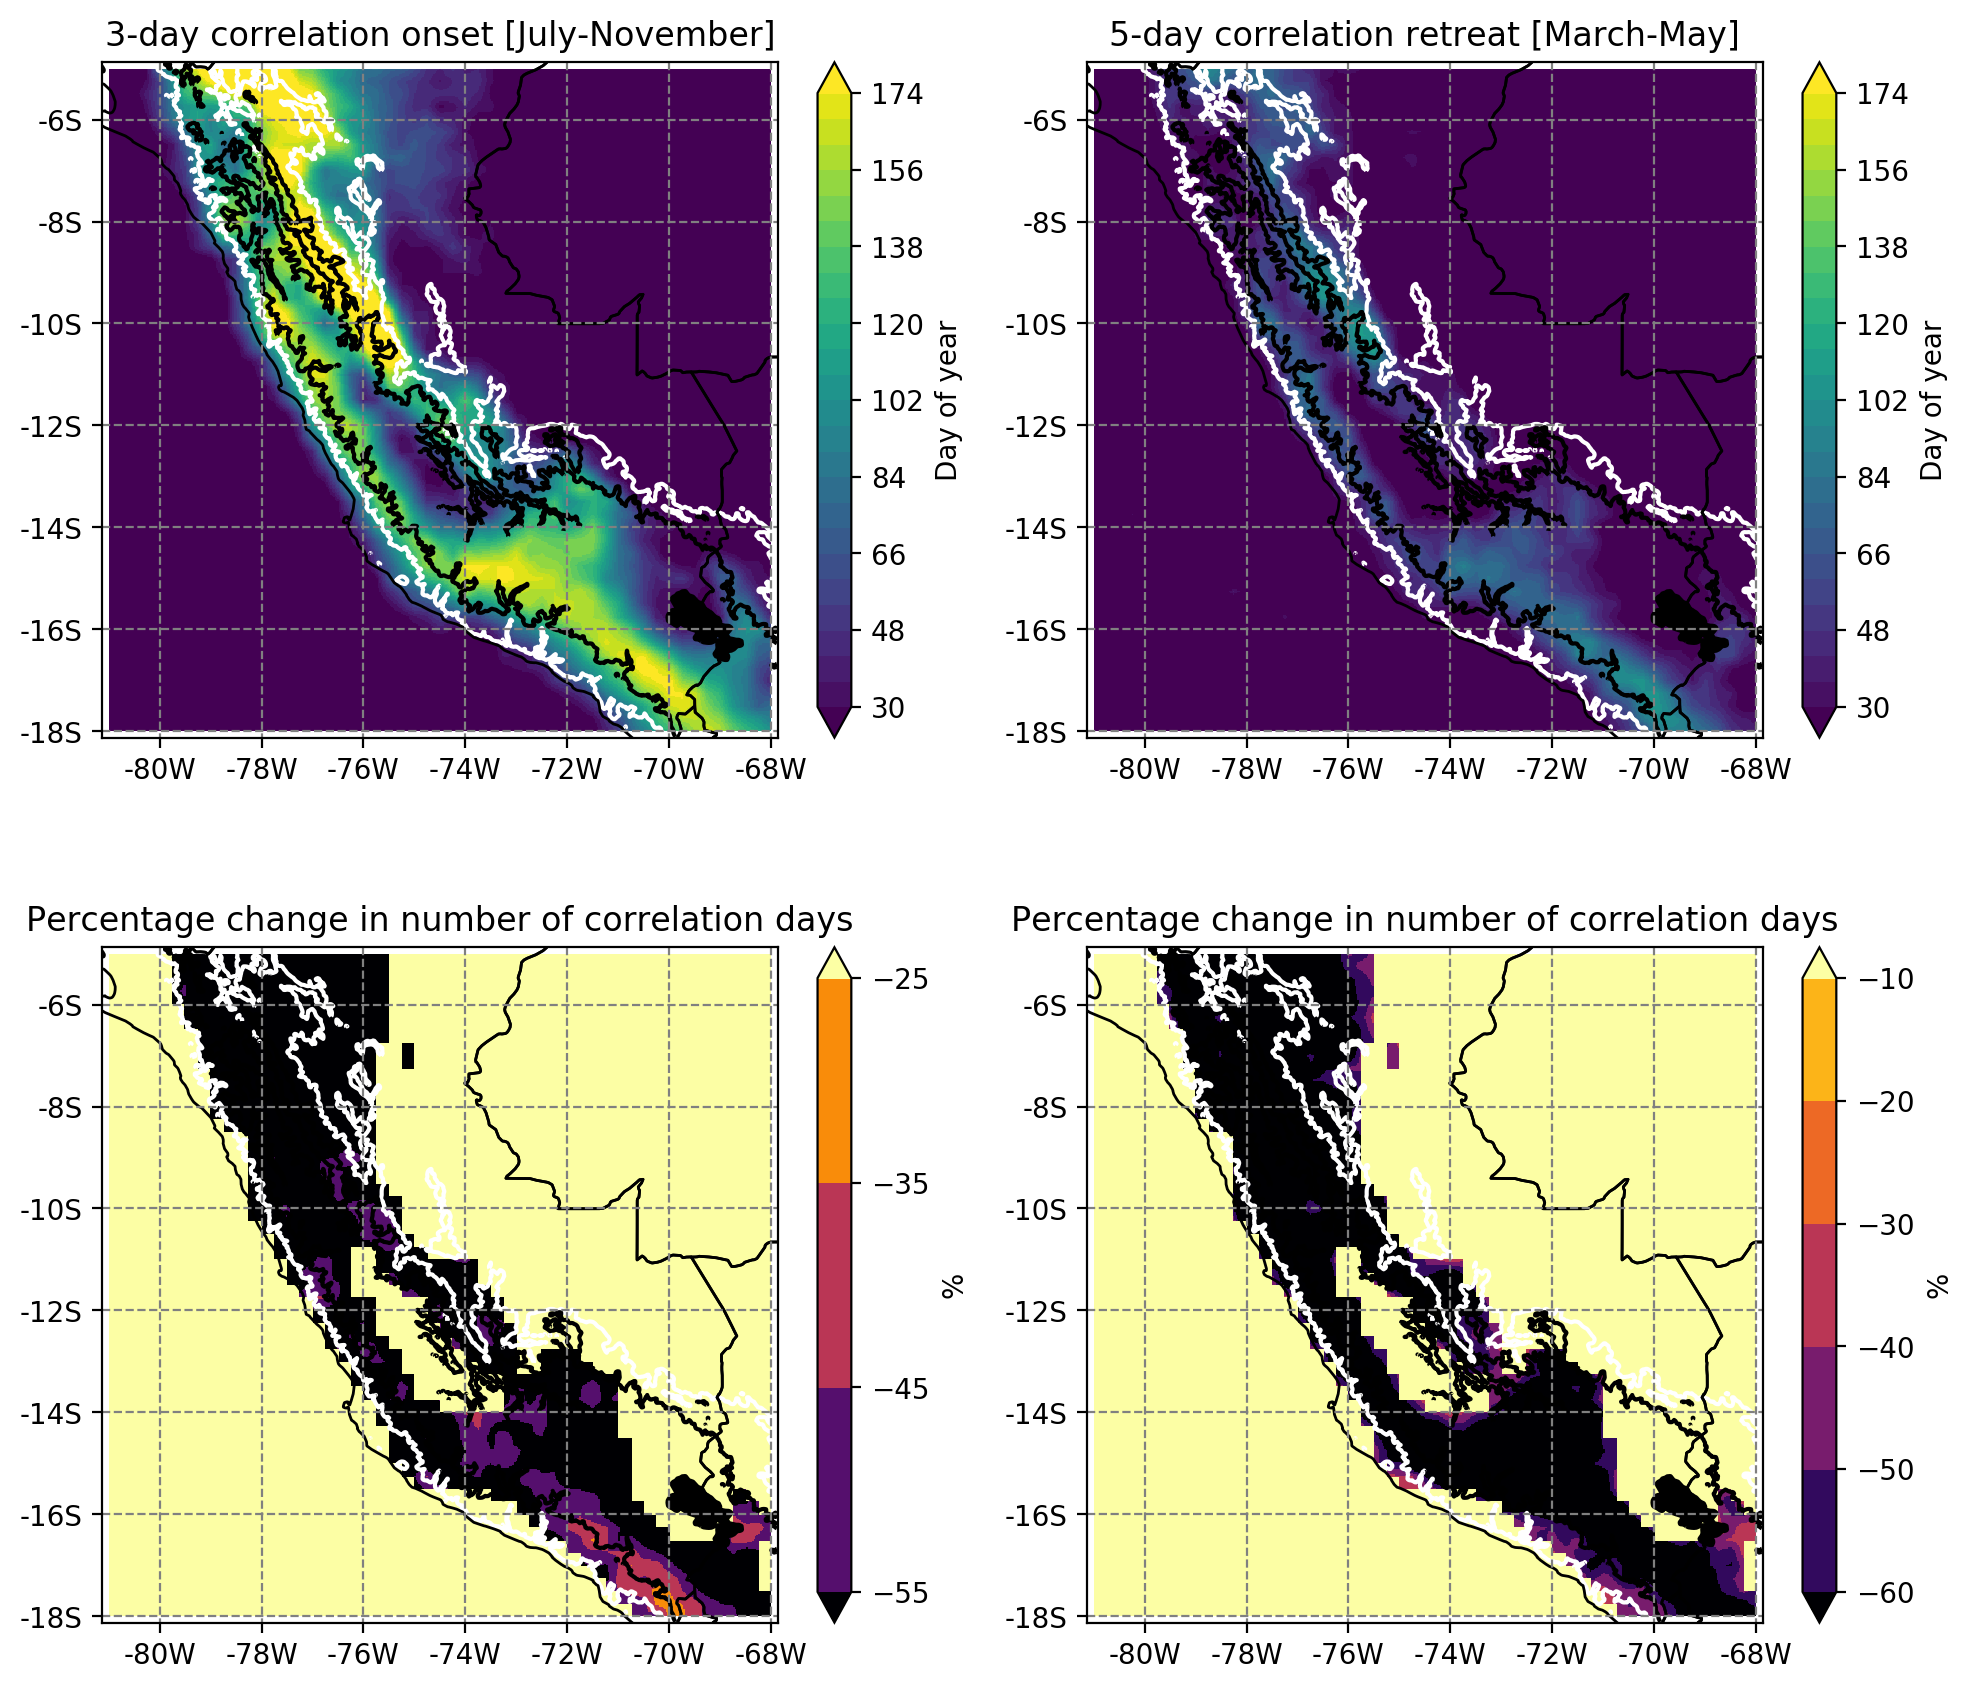

In [20]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(10,9), dpi=200)

ax = f.add_subplot(221)

map.set_data(corr_all_num, interp='linear')
map.set_plot_params(levels=np.arange(30,180,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(222)
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(corr_end_num, interp='linear')
map.set_plot_params(levels=np.arange(30,180,6), cmap='viridis', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')


ax = f.add_subplot(223)
data = ((corr_end_num-corr_all_num)/corr_all_num)*100
data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data, interp='linear')
map.set_plot_params(levels=[-55,-45,-35,-25], cmap='inferno', extend='both')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')


ax = f.add_subplot(224)
data = ((corr_end_num-corr_all_num))#/corr_all_num)*100
data.values = np.array(data.values).astype(float)
data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data, interp='linear')
map.set_plot_params(levels=[-60,-50,-40,-30,-20,-10], cmap='inferno', extend='both')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')


plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_correl.png')

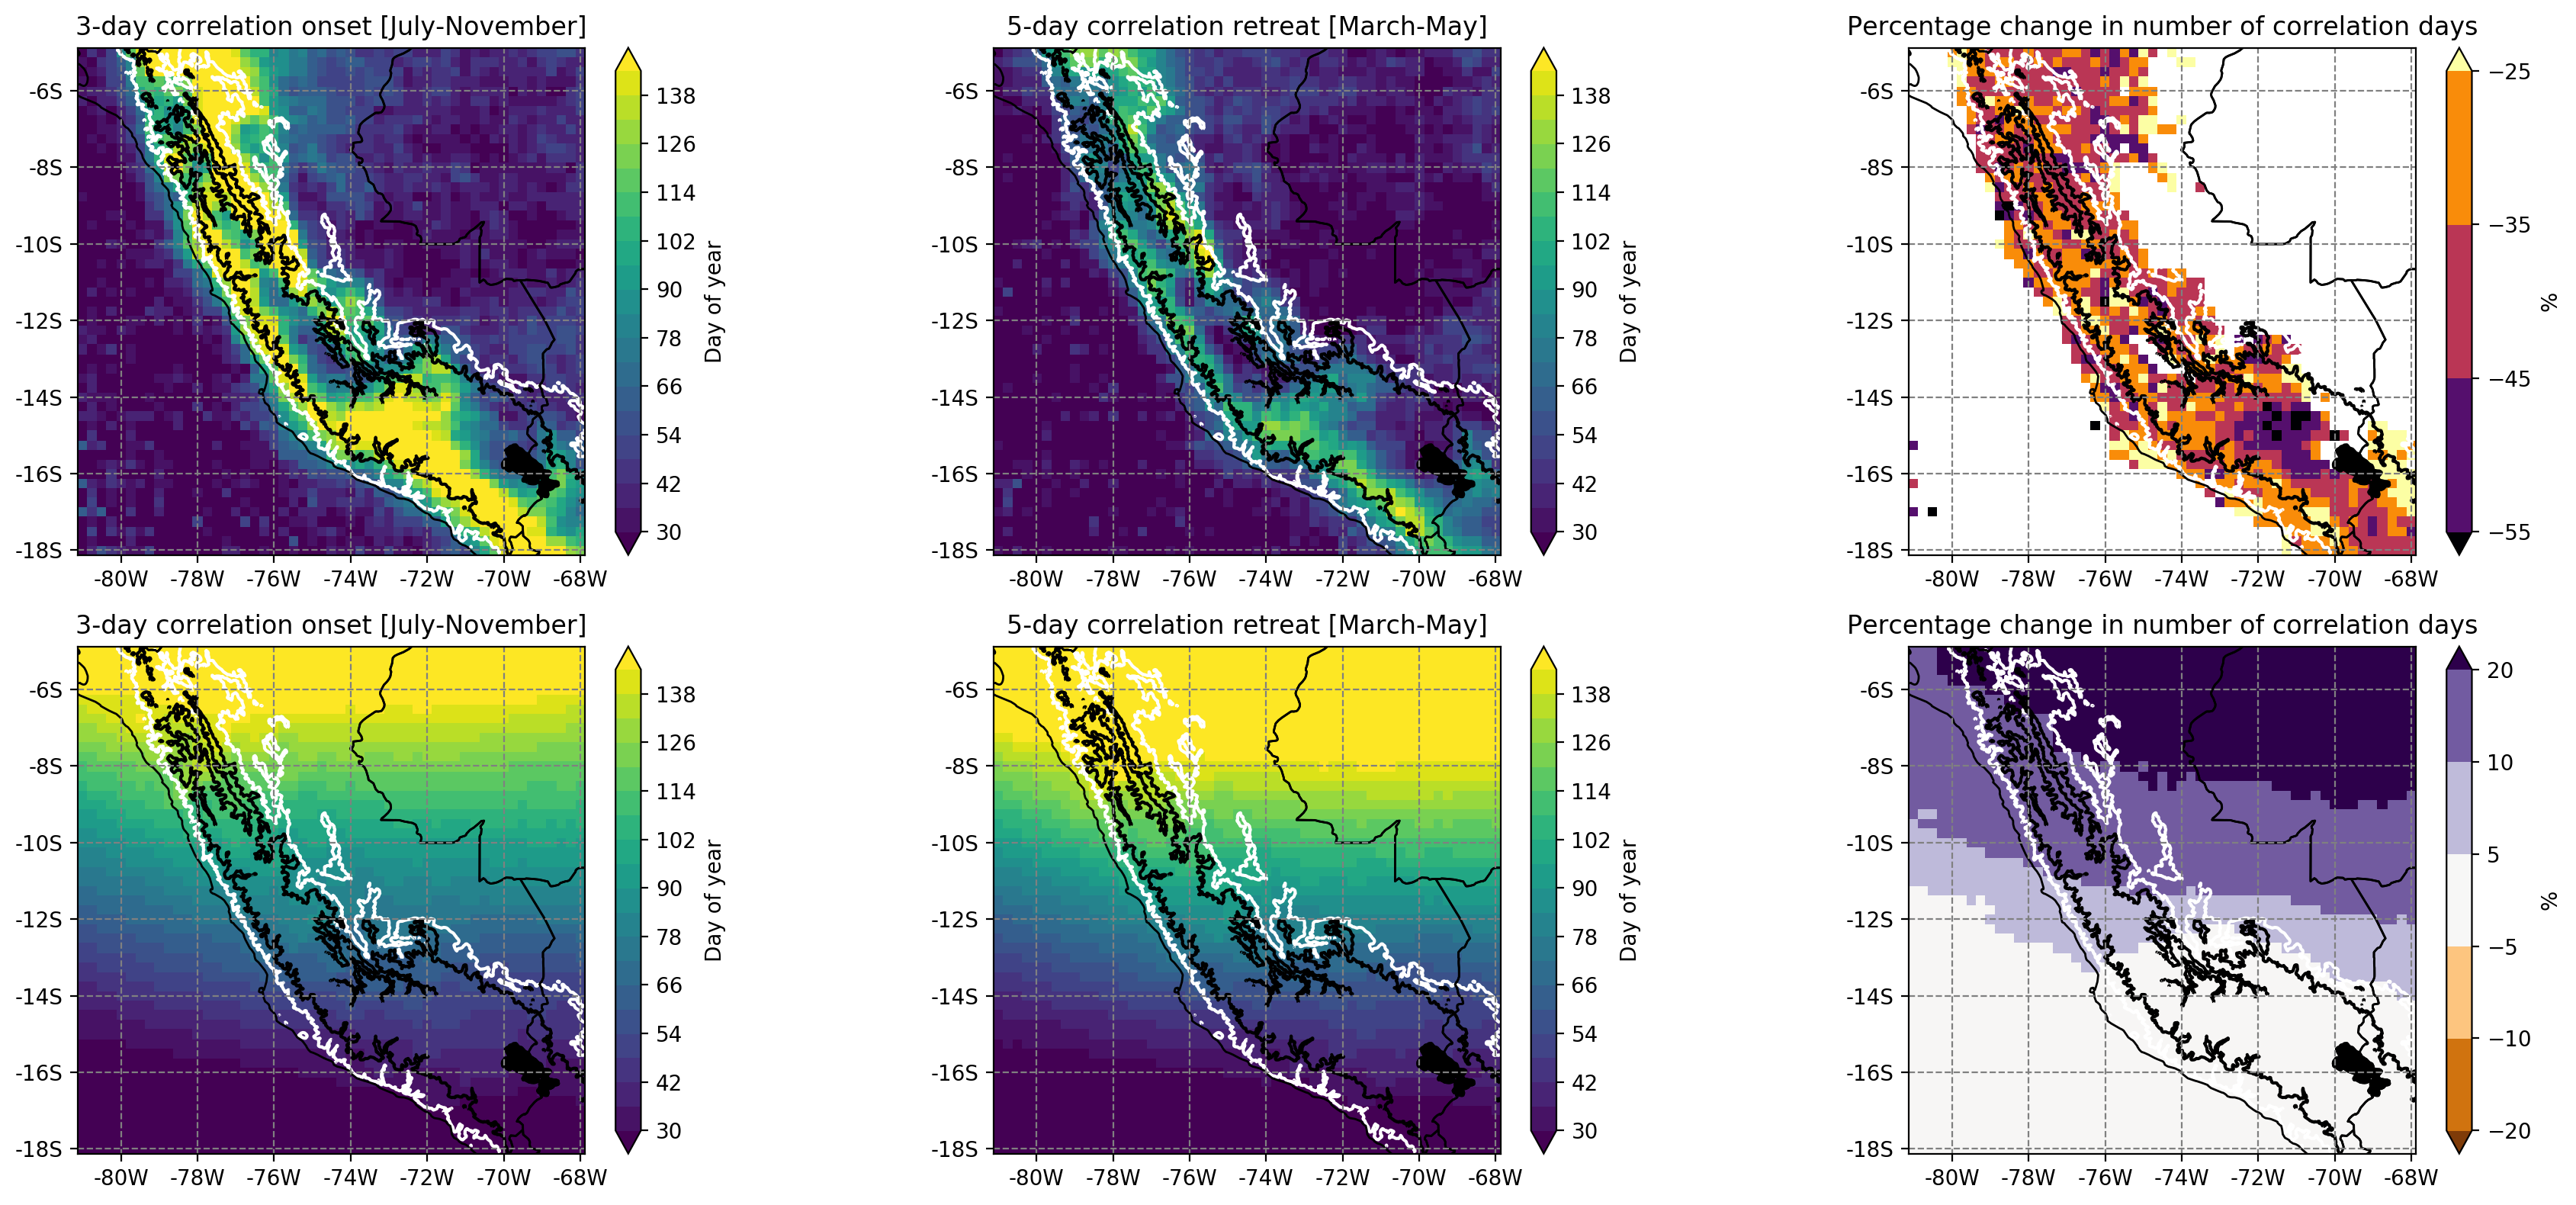

In [78]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(18,8), dpi=200)

ax = f.add_subplot(231)

map.set_data(corr_all_num)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(232)
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(corr_end_num)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
data = ((corr_end_num-corr_all_num)/corr_all_num)*100
data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-55,-45,-35,-25], cmap='inferno', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)

map.set_data(era_all)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(235)
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(era_end)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(236)
data = ((era_end-era_all))#/era_all)*100
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-10,-5,5,10,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_corr.png')

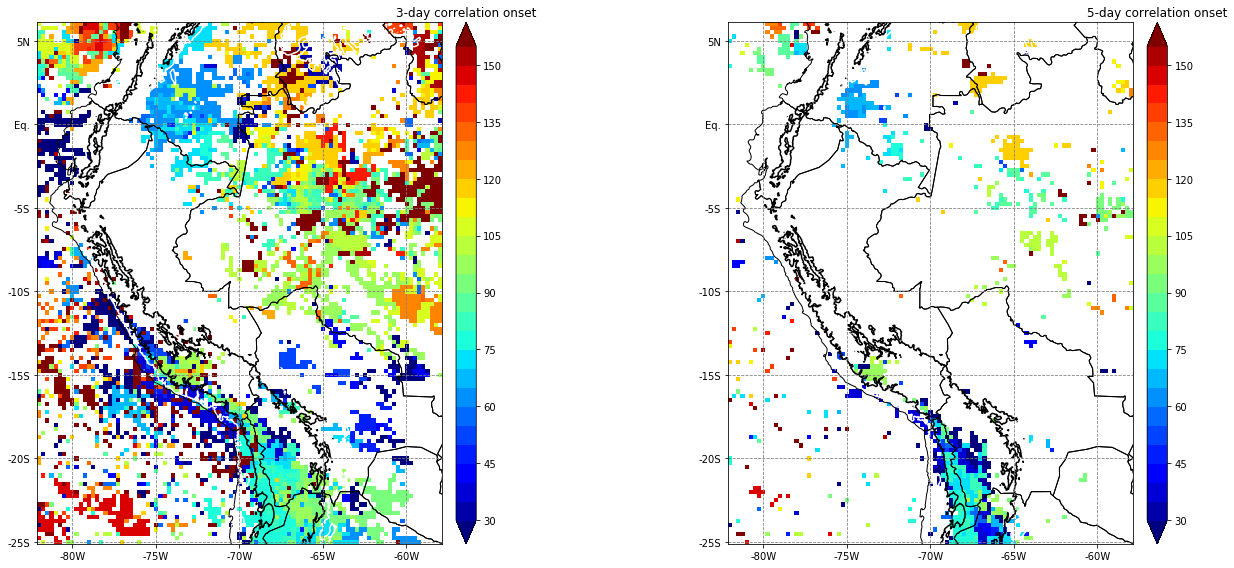

In [39]:
map = corr_sig.salem.get_map()
f = plt.figure(figsize=(20,8))

ax = f.add_subplot(121)

map.set_data(endarr_3)
map.set_plot_params(levels=np.arange(30,156,5), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize()
plt.plot(-77.5, -9.5, 'ro')
plt.title('3-day correlation onset')

ax = f.add_subplot(122)

map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(30,156,5), cmap='jet', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize()
plt.plot(-77.5, -9.5, 'ro')
plt.title('5-day correlation onset')

plt.tight_layout()

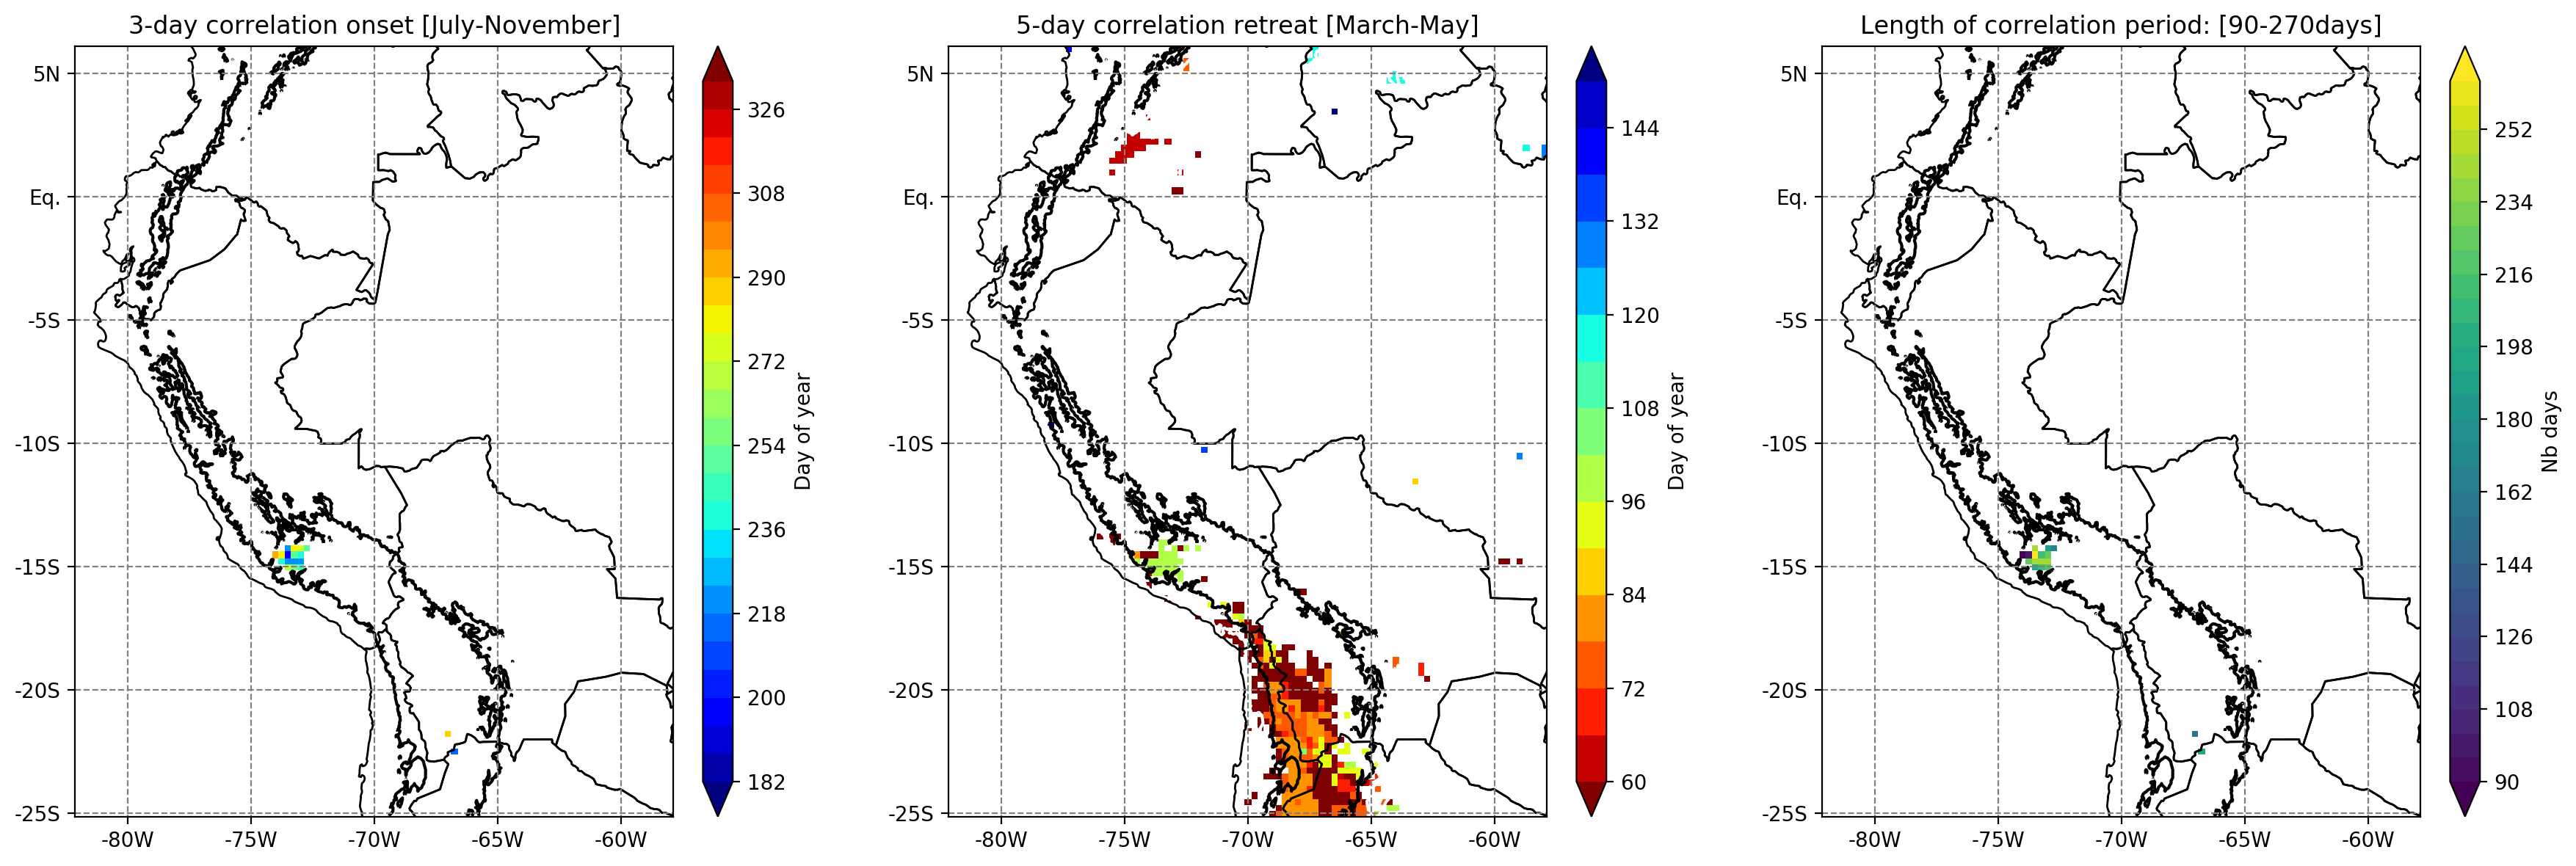

In [40]:
map = corr_all.salem.get_map()
f = plt.figure(figsize=(18,6), dpi=200)

ax = f.add_subplot(131)

map.set_data(outarr_3)
map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(132)
endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(133)
endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data((365-outarr_3)+endarr_5)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200_CCT_correlation_1999-2019.png')

In [311]:
ispos = corr_all.isel(dayofyear=1).where((corr_all.longitude==-77.5)&(corr_all.latitude==-9.5))
pickpos = np.where(np.isfinite(ispos['r']))
y = int(pickpos[0])
x = int(pickpos[1])
date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(outarr_3[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz onset', outarr_3[y,x], 'Date', dstr)
date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(endarr_5[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz retreat', endarr_5[y,x], 'Date', dstr)

Huaraz onset 267.0 Date 24/09
Huaraz retreat 112.0 Date 22/04
